In [1]:
from keras.applications.convnext import LayerScale
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.metrics import confusion_matrix, f1_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

## Load data

In [2]:
TARGET_HEIGHT = 640
TARGET_WIDTH = 640

In [3]:
root_directory = '/data/CheXpert-v1.0'
valid_folder = os.path.join(root_directory, 'valid')
valid_labels_df = pd.read_csv(os.path.join(root_directory, 'valid.csv'))

In [4]:
valid_labels_df.shape

(234, 19)

In [5]:
chexnet_targets = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

In [6]:
# use 1 as positive and everything else and negative

u_one_features = []
u_zero_features = chexnet_targets 

In [7]:
def label_u_one_features(df: pd.DataFrame, column: str):
    return np.where((df[column] == 1) | (df[column] == -1), 1, 0)

def label_u_zero_features(df: pd.DataFrame, column: str):
    return np.where(df[column] == 1, 1, 0)

In [8]:
valid_labels_df['patient'] = valid_labels_df['Path'].apply(lambda x: os.path.split(os.path.split(os.path.split(x)[0])[0])[1])
valid_labels_df['study'] = valid_labels_df['Path'].apply(lambda x: os.path.split(os.path.split(x)[0])[1])

In [9]:
def feature_string(row):
    feature_list = []
    for feature in u_one_features:
        if row[feature] in [-1,1]:
            feature_list.append(feature)
            
    for feature in u_zero_features:
        if row[feature] == 1:
            feature_list.append(feature)
            
    return ';'.join(feature_list)

In [10]:
valid_labels_df['feature_string'] = valid_labels_df.apply(feature_string,axis = 1).fillna('')
valid_labels_df['feature_string'] = valid_labels_df['feature_string'].apply(lambda x:x.split(";"))

In [11]:
for col in u_one_features:
    valid_labels_df[f'{col}_u_one'] = label_u_one_features(df=valid_labels_df, column=col)
for col in u_zero_features:
    valid_labels_df[f'{col}_u_zero'] = label_u_zero_features(df=valid_labels_df, column=col)

In [12]:
valid_labels_df['path'] = '/data/' + valid_labels_df['Path']

In [13]:
targets = [target + '_u_zero' for target in u_zero_features]

In [14]:
X_val = valid_labels_df['path'].values
y_val = valid_labels_df[targets].values

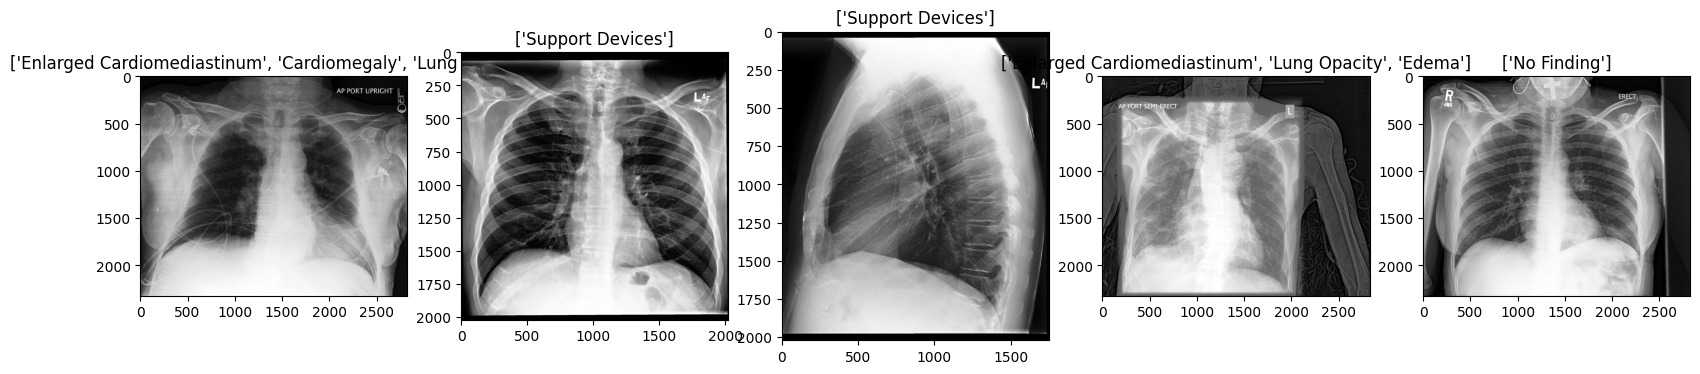

In [15]:
#get the first 5 images
paths =  valid_labels_df.path[:5]
labels = valid_labels_df.feature_string[:5]

fig, m_axs = plt.subplots(1, len(labels), figsize = (20, 10))
#show the images and label them
for ii, c_ax in enumerate(m_axs):
    c_ax.imshow(np.asarray(Image.open(paths[ii])), cmap='gray')
    c_ax.set_title(labels[ii])
plt.show()

## Load model

In [16]:
MODEL_NAME = 'pretrain_model_ConvNeXtBase_w_ClssWgt_01-0.3616.h5'

In [17]:
model_path = f'../models/{MODEL_NAME}'

In [18]:
model = tf.keras.models.load_model(model_path, custom_objects={'LayerScale': LayerScale})

In [19]:
model.summary()

Model: "Xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageInput (InputLayer)        [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_base_stem (Sequential  (None, 160, 160, 12  6528       ['ImageInput[0][0]']             
 )                              8)                                                                
                                                                                                  
 convnext_base_stage_0_block_0_  (None, 160, 160, 12  6400       ['convnext_base_stem[0][0]']     
 depthwise_conv (Conv2D)        8)                                                         

                                                                                                  
 convnext_base_downsampling_blo  (None, 80, 80, 256)  131584     ['tf.__operators__.add_2[0][0]'] 
 ck_0 (Sequential)                                                                                
                                                                                                  
 convnext_base_stage_1_block_0_  (None, 80, 80, 256)  12800      ['convnext_base_downsampling_bloc
 depthwise_conv (Conv2D)                                         k_0[0][0]']                      
                                                                                                  
 convnext_base_stage_1_block_0_  (None, 80, 80, 256)  512        ['convnext_base_stage_1_block_0_d
 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_

 convnext_base_stage_2_block_0_  (None, 40, 40, 512)  25600      ['convnext_base_downsampling_bloc
 depthwise_conv (Conv2D)                                         k_1[0][0]']                      
                                                                                                  
 convnext_base_stage_2_block_0_  (None, 40, 40, 512)  1024       ['convnext_base_stage_2_block_0_d
 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_base_stage_2_block_0_  (None, 40, 40, 2048  1050624    ['convnext_base_stage_2_block_0_l
 pointwise_conv_1 (Dense)       )                                ayernorm[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_0_  (None, 40, 40, 2048  0          ['convnext_base_stage_2_block_0_p
 gelu (Act

 pointwise_conv_1 (Dense)       )                                ayernorm[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_3_  (None, 40, 40, 2048  0          ['convnext_base_stage_2_block_3_p
 gelu (Activation)              )                                ointwise_conv_1[0][0]']          
                                                                                                  
 convnext_base_stage_2_block_3_  (None, 40, 40, 512)  1049088    ['convnext_base_stage_2_block_3_g
 pointwise_conv_2 (Dense)                                        elu[0][0]']                      
                                                                                                  
 convnext_base_stage_2_block_3_  (None, 40, 40, 512)  512        ['convnext_base_stage_2_block_3_p
 layer_scale (LayerScale)                                        ointwise_conv_2[0][0]']          
          

 convnext_base_stage_2_block_6_  (None, 40, 40, 512)  512        ['convnext_base_stage_2_block_6_p
 layer_scale (LayerScale)                                        ointwise_conv_2[0][0]']          
                                                                                                  
 convnext_base_stage_2_block_6_  (None, 40, 40, 512)  0          ['convnext_base_stage_2_block_6_l
 identity (Activation)                                           ayer_scale[0][0]']               
                                                                                                  
 tf.__operators__.add_12 (TFOpL  (None, 40, 40, 512)  0          ['tf.__operators__.add_11[0][0]',
 ambda)                                                           'convnext_base_stage_2_block_6_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_

                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_base_stage_2_block_10  (None, 40, 40, 512)  25600      ['tf.__operators__.add_15[0][0]']
 _depthwise_conv (Conv2D)                                                                         
                                                                                                  
 convnext_base_stage_2_block_10  (None, 40, 40, 512)  1024       ['convnext_base_stage_2_block_10_
 _layernorm (LayerNormalization                                  depthwise_conv[0][0]']           
 )                                                                                                
                                                                                                  
 convnext_base_stage_2_block_10  (None, 40, 40, 2048  1050624    ['convnext_base_stage_2_block_10_
 _pointwis

 convnext_base_stage_2_block_13  (None, 40, 40, 512)  1024       ['convnext_base_stage_2_block_13_
 _layernorm (LayerNormalization                                  depthwise_conv[0][0]']           
 )                                                                                                
                                                                                                  
 convnext_base_stage_2_block_13  (None, 40, 40, 2048  1050624    ['convnext_base_stage_2_block_13_
 _pointwise_conv_1 (Dense)      )                                layernorm[0][0]']                
                                                                                                  
 convnext_base_stage_2_block_13  (None, 40, 40, 2048  0          ['convnext_base_stage_2_block_13_
 _gelu (Activation)             )                                pointwise_conv_1[0][0]']         
                                                                                                  
 convnext_

 _pointwise_conv_1 (Dense)      )                                layernorm[0][0]']                
                                                                                                  
 convnext_base_stage_2_block_16  (None, 40, 40, 2048  0          ['convnext_base_stage_2_block_16_
 _gelu (Activation)             )                                pointwise_conv_1[0][0]']         
                                                                                                  
 convnext_base_stage_2_block_16  (None, 40, 40, 512)  1049088    ['convnext_base_stage_2_block_16_
 _pointwise_conv_2 (Dense)                                       gelu[0][0]']                     
                                                                                                  
 convnext_base_stage_2_block_16  (None, 40, 40, 512)  512        ['convnext_base_stage_2_block_16_
 _layer_scale (LayerScale)                                       pointwise_conv_2[0][0]']         
          

 convnext_base_stage_2_block_19  (None, 40, 40, 512)  1049088    ['convnext_base_stage_2_block_19_
 _pointwise_conv_2 (Dense)                                       gelu[0][0]']                     
                                                                                                  
 convnext_base_stage_2_block_19  (None, 40, 40, 512)  512        ['convnext_base_stage_2_block_19_
 _layer_scale (LayerScale)                                       pointwise_conv_2[0][0]']         
                                                                                                  
 convnext_base_stage_2_block_19  (None, 40, 40, 512)  0          ['convnext_base_stage_2_block_19_
 _identity (Activation)                                          layer_scale[0][0]']              
                                                                                                  
 tf.__operators__.add_25 (TFOpL  (None, 40, 40, 512)  0          ['tf.__operators__.add_24[0][0]',
 ambda)   

                                                                                                  
 convnext_base_stage_2_block_22  (None, 40, 40, 512)  0          ['convnext_base_stage_2_block_22_
 _identity (Activation)                                          layer_scale[0][0]']              
                                                                                                  
 tf.__operators__.add_28 (TFOpL  (None, 40, 40, 512)  0          ['tf.__operators__.add_27[0][0]',
 ambda)                                                           'convnext_base_stage_2_block_22_
                                                                 identity[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_23  (None, 40, 40, 512)  25600      ['tf.__operators__.add_28[0][0]']
 _depthwise_conv (Conv2D)                                                                         
          

 ambda)                                                           'convnext_base_stage_2_block_25_
                                                                 identity[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_26  (None, 40, 40, 512)  25600      ['tf.__operators__.add_31[0][0]']
 _depthwise_conv (Conv2D)                                                                         
                                                                                                  
 convnext_base_stage_2_block_26  (None, 40, 40, 512)  1024       ['convnext_base_stage_2_block_26_
 _layernorm (LayerNormalization                                  depthwise_conv[0][0]']           
 )                                                                                                
                                                                                                  
 convnext_

 convnext_base_stage_3_block_2_  (None, 20, 20, 1024  51200      ['tf.__operators__.add_34[0][0]']
 depthwise_conv (Conv2D)        )                                                                 
                                                                                                  
 convnext_base_stage_3_block_2_  (None, 20, 20, 1024  2048       ['convnext_base_stage_3_block_2_d
 layernorm (LayerNormalization)  )                               epthwise_conv[0][0]']            
                                                                                                  
 convnext_base_stage_3_block_2_  (None, 20, 20, 4096  4198400    ['convnext_base_stage_3_block_2_l
 pointwise_conv_1 (Dense)       )                                ayernorm[0][0]']                 
                                                                                                  
 convnext_base_stage_3_block_2_  (None, 20, 20, 4096  0          ['convnext_base_stage_3_block_2_p
 gelu (Act

## Store predictions

Store all predictions in a dataframe

CAUTION! Make sure the preprocessing matches what was used during model training 

In [20]:
def convert_image_to_array(path):
    img = np.asarray(Image.open(path), dtype=np.float32)
    img = np.stack((img,)*3, axis=-1)
    img /= 255.
    img = tf.image.resize_with_pad(img, target_height=TARGET_HEIGHT, target_width=TARGET_WIDTH)
    return img

In [21]:
def model_predict(path, model):
    x = convert_image_to_array(path=path)
    x = np.expand_dims(x, axis=0)
    return model.predict(x)

In [22]:
pred_columns = [col_name + '_pred' for col_name in targets]
target_columns = [col_name + '_label' for col_name in targets]

In [23]:
all_model_preds = pd.DataFrame(0, index=np.arange(len(X_val)), columns=pred_columns)

In [24]:
for i, path in enumerate(X_val):
    if i % 10 == 0:
        print(f'{i} out of {len(X_val)}')
    all_model_preds.iloc[i, :] = model_predict(path=path, model=model)[0]

0 out of 234
1/1 [==============================] - 0s 65ms/step
10 out of 234
1/1 [==============================] - 0s 63ms/step
20 out of 234
1/1 [==============================] - 0s 65ms/step
30 out of 234
1/1 [==============================] - 0s 65ms/step
40 out of 234
1/1 [==============================] - 0s 62ms/step
50 out of 234
1/1 [==============================] - 0s 61ms/step
60 out of 234
1/1 [==============================] - 0s 64ms/step
70 out of 234
1/1 [==============================] - 0s 66ms/step
80 out of 234
1/1 [==============================] - 0s 60ms/step
90 out of 234
1/1 [==============================] - 0s 65ms/step
100 out of 234
1/1 [==============================] - 0s 61ms/step
110 out of 234
1/1 [==============================] - 0s 65ms/step
120 out of 234
1/1 [==============================] - 0s 66ms/step
130 out of 234
1/1 [==============================] - 0s 64ms/step
140 out of 234
1/1 [==============================] - 0s 64ms/step
150 ou

1/1 [==============================] - 0s 66ms/step
160 out of 234
1/1 [==============================] - 0s 64ms/step
170 out of 234
1/1 [==============================] - 0s 63ms/step
180 out of 234
1/1 [==============================] - 0s 64ms/step
190 out of 234
1/1 [==============================] - 0s 66ms/step
200 out of 234
1/1 [==============================] - 0s 65ms/step
210 out of 234
1/1 [==============================] - 0s 60ms/step
220 out of 234
1/1 [==============================] - 0s 60ms/step
230 out of 234
1/1 [==============================] - 0s 66ms/step


In [25]:
all_model_preds

,No Finding_u_zero_pred,Enlarged Cardiomediastinum_u_zero_pred,Cardiomegaly_u_zero_pred,Lung Opacity_u_zero_pred,Lung Lesion_u_zero_pred,Edema_u_zero_pred,Consolidation_u_zero_pred,Pneumonia_u_zero_pred,Atelectasis_u_zero_pred,Pneumothorax_u_zero_pred,Pleural Effusion_u_zero_pred,Pleural Other_u_zero_pred,Fracture_u_zero_pred,Support Devices_u_zero_pred
0,0.127851,0.058769,0.108261,0.293889,0.037505,0.079250,0.051099,0.032572,0.361624,0.020518,0.057389,0.007767,0.099140,0.050465
1,0.659075,0.044580,0.018225,0.024824,0.037766,0.000758,0.005020,0.009146,0.013645,0.004206,0.015643,0.021356,0.025415,0.932087
2,0.557868,0.057511,0.020068,0.036534,0.063073,0.001381,0.006280,0.013144,0.023791,0.012601,0.010785,0.040784,0.060211,0.760305
3,0.032782,0.149955,0.062713,0.408865,0.155388,0.074200,0.107584,0.102657,0.050355,0.077145,0.068873,0.087867,0.195781,0.062978
4,0.626823,0.041552,0.006266,0.033741,0.026988,0.005968,0.010063,0.015875,0.036150,0.050523,0.006111,0.010777,0.147558,0.167777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,0.205048,0.158321,0.116423,0.246780,0.038780,0.114996,0.024691,0.016768,0.112752,0.049413,0.059821,0.035374,0.054200,0.889937
230,0.366328,0.032918,0.021907,0.135501,0.018728,0.051138,0.017319,0.009877,0.363849,0.009758,0.075883,0.003660,0.020051,0.968267
231,0.080245,0.213591,0.297854,0.346397,0.038199,0.456982,0.025184,0.022276,0.153383,0.014021,0.034779,0.010789,0.066752,0.602818
232,0.333008,0.071837,0.104798,0.053646,0.021355,0.010043,0.005724,0.008483,0.027619,0.006399,0.004973,0.005443,0.073455,0.027290


In [26]:
results = pd.DataFrame(data=y_val, columns=target_columns)
results = pd.concat([results, all_model_preds], axis=1)

In [27]:
y = results[target_columns].values
pred = results[pred_columns].values

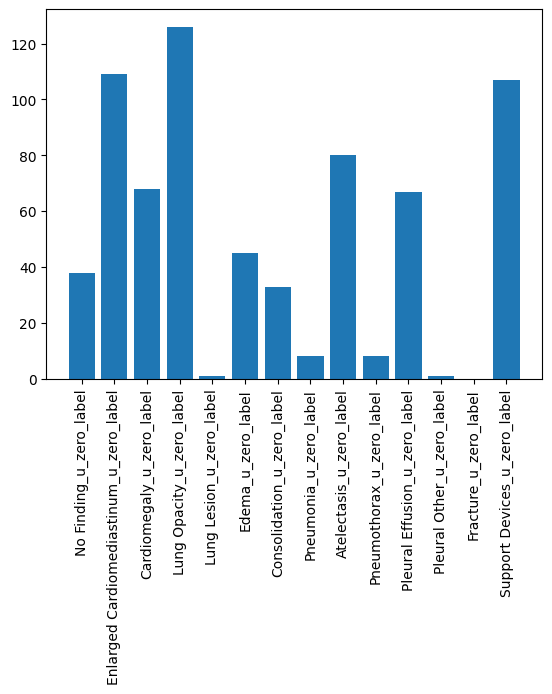

In [28]:
plt.xticks(rotation=90)
plt.bar(x = target_columns, height= y.sum(axis=0))
plt.show()

## Calculate metrics

In [29]:
def true_positives(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 1))


def true_negatives(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 0))


def false_negatives(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == False) & (y == 1))


def false_positives(y, pred, th=0.5):
    pred_t = (pred > th)
    return np.sum((pred_t == True) & (y == 0))

In [38]:
def get_performance_metrics(y, pred, class_labels, tp=true_positives,
                            tn=true_negatives, fp=false_positives,
                            fn=false_negatives,
                            acc=None, prevalence=None, spec=None,
                            sens=None, ppv=None, npv=None, auc=None, f1=None,
                            thresholds=[]):
    if len(thresholds) != len(class_labels):
        thresholds = [.5] * len(class_labels)

    metrics = [tp, tn, fp, fn, acc, prevalence, sens, spec, ppv, npv, auc, f1]
    metric_names = ["TP", "TN", "FP", "FN", "Accuracy", "Prevalence",
                    "Sensitivity", "Specificity", "PPV", "NPV", "AUC", "F1"]

    df = pd.DataFrame(index=class_labels, columns=metric_names + ["Threshold"])

    for i, label in enumerate(class_labels):
        for metric, name in zip(metrics, metric_names):
            if metric is not None:
                try:
                    if name in ["AUC", "F1"]:
                        df.loc[label, name] = round(metric(y[:, i], pred[:, i]), 3)
                    elif name == "Prevalence":
                        df.loc[label, name] = round(metric(y[:, i]), 3)
                    else:
                        df.loc[label, name] = round(metric(y[:, i], pred[:, i], thresholds[i]), 3)
                except Exception as e:
                    print(f"Exception occurred in {name}: {e}")
                    df.loc[label, name] = np.NAN
            else:
                df.loc[label, name] = "Not Defined"
        df.loc[label, "Threshold"] = round(thresholds[i], 3)

    return df

In [39]:
def print_confidence_intervals(class_labels, statistics):
    df = pd.DataFrame(columns=["Mean AUC (CI 5%-95%)"])
    for i in range(len(class_labels)):
        mean = statistics.mean(axis=1)[i]
        max_ = np.quantile(statistics, .95, axis=1)[i]
        min_ = np.quantile(statistics, .05, axis=1)[i]
        df.loc[class_labels[i]] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
    return df


def get_curve(gt, pred, target_names, curve='roc'):
    for i in range(len(target_names)):
        if curve == 'roc':
            curve_function = roc_curve
            auc_roc = roc_auc_score(gt[:, i], pred[:, i])
            label = target_names[i] + " AUC: %.3f " % auc_roc
            xlabel = "False positive rate"
            ylabel = "True positive rate"
            a, b, _ = curve_function(gt[:, i], pred[:, i])
            plt.figure(1, figsize=(7, 7))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(a, b, label=label)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)

            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)
        elif curve == 'prc':
            precision, recall, _ = precision_recall_curve(gt[:, i], pred[:, i])
            average_precision = average_precision_score(gt[:, i], pred[:, i])
            label = target_names[i] + " Avg.: %.3f " % average_precision
            plt.figure(1, figsize=(7, 7))
            plt.step(recall, precision, where='post', label=label)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                       fancybox=True, ncol=1)

In [40]:
def get_accuracy(y, pred, th=0.5):
    """
    Compute accuracy of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        accuracy (float): accuracy of predictions at threshold
    """
    TP = true_positives(y, pred, th)
    FP = false_positives(y, pred, th)
    TN = true_negatives(y, pred, th)
    FN = false_negatives(y, pred, th)

    total = TP + TN + FP + FN
    accuracy = (TP + TN) / total if total else 0.0
    
    return accuracy

def get_prevalence(y):
    """
    Compute prevalence of positive cases.

    Args:
        y (np.array): ground truth, size (n_examples)
    Returns:
        prevalence (float): prevalence of positive cases
    """
    total = len(y)
    prevalence = np.sum(y) / total if total else 0.0
    
    return prevalence

def get_sensitivity(y, pred, th=0.5):
    """
    Compute sensitivity of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        sensitivity (float): probability that our test outputs positive given that the case is actually positive
    """
    TP = true_positives(y, pred, th)
    FN = false_negatives(y, pred, th)

    total = TP + FN
    sensitivity = TP / total if total else 0.0
    
    return sensitivity

def get_specificity(y, pred, th=0.5):
    """
    Compute specificity of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        specificity (float): probability that the test outputs negative given that the case is actually negative
    """
    TN = true_negatives(y, pred, th)
    FP = false_positives(y, pred, th)
    
    total = TN + FP
    specificity = TN / total if total else 0.0
    
    return specificity

def get_ppv(y, pred, th=0.5):
    """
    Compute PPV of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        PPV (float): positive predictive value of predictions at threshold
    """
    TP = true_positives(y, pred, th)
    FP = false_positives(y, pred, th)

    total = TP + FP
    PPV = TP / total if total else 0.0
    
    return PPV

def get_npv(y, pred, th=0.5):
    """
    Compute NPV of predictions at threshold.

    Args:
        y (np.array): ground truth, size (n_examples)
        pred (np.array): model output, size (n_examples)
        th (float): cutoff value for positive prediction from model
    Returns:
        NPV (float): negative predictive value of predictions at threshold
    """
    TN = true_negatives(y, pred, th)
    FN = false_negatives(y, pred, th)

    total = TN + FN
    NPV = TN / total if total else 0.0
    
    return NPV

In [41]:
get_performance_metrics(y, pred, target_columns, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score, f1=f1_score)

Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuou

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
No Finding_u_zero_label,16,177,19,22,0.825,0.162,0.421,0.903,0.457,0.889,0.849,NaN,0.5
Enlarged Cardiomediastinum_u_zero_label,1,125,0,108,0.538,0.466,0.009,1.0,1.0,0.536,0.616,NaN,0.5
Cardiomegaly_u_zero_label,12,166,0,56,0.761,0.291,0.176,1.0,1.0,0.748,0.838,NaN,0.5
Lung Opacity_u_zero_label,40,108,0,86,0.632,0.538,0.317,1.0,1.0,0.557,0.932,NaN,0.5
Lung Lesion_u_zero_label,0,233,0,1,0.996,0.004,0.0,1.0,0.0,0.996,0.124,NaN,0.5
Edema_u_zero_label,18,182,7,27,0.855,0.192,0.4,0.963,0.72,0.871,0.91,NaN,0.5
Consolidation_u_zero_label,0,201,0,33,0.859,0.141,0.0,1.0,0.0,0.859,0.897,NaN,0.5
Pneumonia_u_zero_label,0,226,0,8,0.966,0.034,0.0,1.0,0.0,0.966,0.573,NaN,0.5
Atelectasis_u_zero_label,6,154,0,74,0.684,0.342,0.075,1.0,1.0,0.675,0.803,NaN,0.5
Pneumothorax_u_zero_label,3,216,10,5,0.936,0.034,0.375,0.956,0.231,0.977,0.949,NaN,0.5


In [44]:
def bootstrap_auc(y, pred, classes, bootstraps=100, fold_size=1000):
    statistics = np.full((len(classes), bootstraps), 0.0)

    for c in range(len(classes)):
        df = pd.DataFrame({'y': y[:, c], 'pred': pred[:, c]})
        prevalences = df.groupby('y').size() / len(df)

        for i in range(bootstraps):
            samples = df.groupby('y').apply(lambda group: group.sample(n=int(fold_size * prevalences[group.name]), replace=True))
            y_sample = samples.y.values
            pred_sample = samples.pred.values

            try:
                statistics[c, i] = roc_auc_score(y_sample, pred_sample)
            except ValueError:
                pass  # Keep default score of 0 if AUC cannot be calculated

    return statistics

statistics = bootstrap_auc(y, pred, target_columns)

In [45]:
print_confidence_intervals(target_columns, statistics)

,Mean AUC (CI 5%-95%)
No Finding_u_zero_label,0.85 (0.83-0.87)
Enlarged Cardiomediastinum_u_zero_label,0.62 (0.59-0.65)
Cardiomegaly_u_zero_label,0.84 (0.81-0.86)
Lung Opacity_u_zero_label,0.93 (0.92-0.95)
Lung Lesion_u_zero_label,0.12 (0.11-0.14)
Edema_u_zero_label,0.91 (0.90-0.93)
Consolidation_u_zero_label,0.90 (0.88-0.91)
Pneumonia_u_zero_label,0.58 (0.51-0.65)
Atelectasis_u_zero_label,0.80 (0.78-0.83)
Pneumothorax_u_zero_label,0.95 (0.93-0.96)


In [46]:
from sklearn.calibration import calibration_curve
def plot_calibration_curve(y, pred):
    plt.figure(figsize=(20, 20))
    for i in range(len(target_columns)):
        plt.subplot(4, 4, i + 1)
        fraction_of_positives, mean_predicted_value = calibration_curve(y[:,i], pred[:,i], n_bins=20)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(mean_predicted_value, fraction_of_positives, marker='.')
        plt.xlabel("Predicted Value")
        plt.ylabel("Fraction of Positives")
        plt.title(target_columns[i])
    plt.tight_layout()
    plt.show()

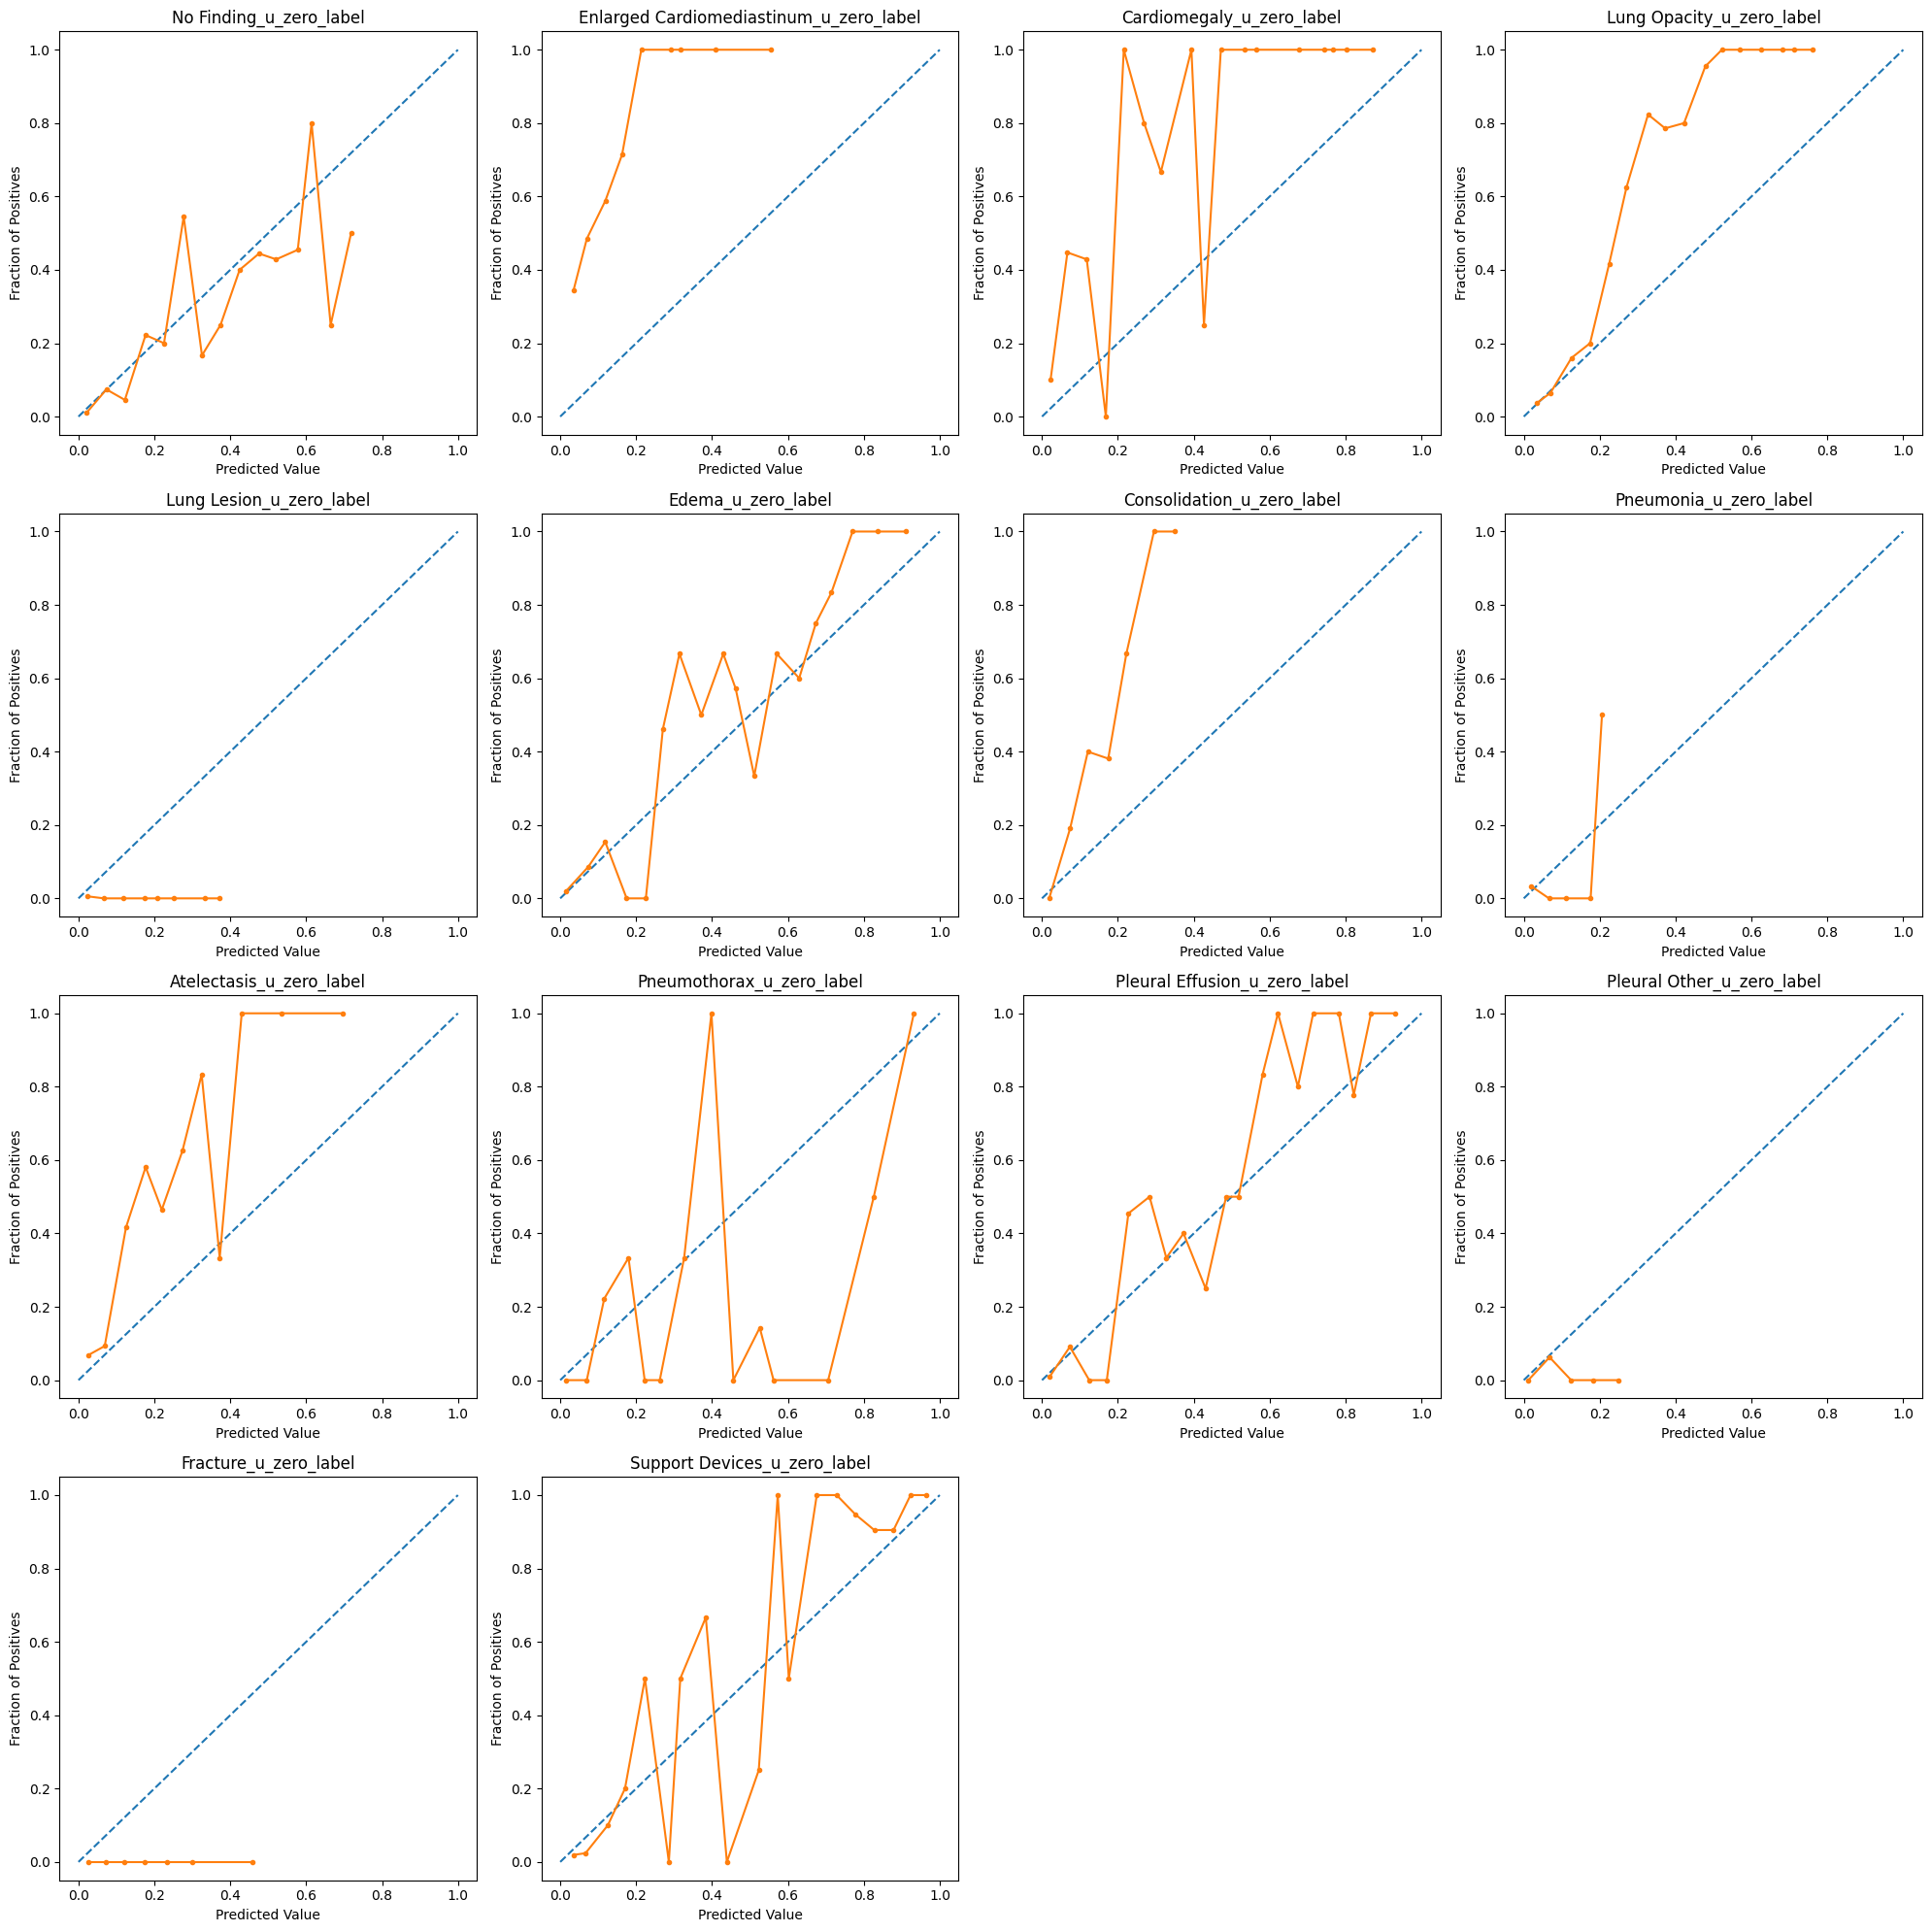

In [47]:
plot_calibration_curve(y, pred)

In [48]:
model_performance_df = get_performance_metrics(y, pred, target_columns, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuou

## Save results to disk

In [49]:
model_performance_df

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
No Finding_u_zero_label,16,177,19,22,0.825,0.162,0.421,0.903,0.457,0.889,0.849,NaN,0.5
Enlarged Cardiomediastinum_u_zero_label,1,125,0,108,0.538,0.466,0.009,1.0,1.0,0.536,0.616,NaN,0.5
Cardiomegaly_u_zero_label,12,166,0,56,0.761,0.291,0.176,1.0,1.0,0.748,0.838,NaN,0.5
Lung Opacity_u_zero_label,40,108,0,86,0.632,0.538,0.317,1.0,1.0,0.557,0.932,NaN,0.5
Lung Lesion_u_zero_label,0,233,0,1,0.996,0.004,0.0,1.0,0.0,0.996,0.124,NaN,0.5
Edema_u_zero_label,18,182,7,27,0.855,0.192,0.4,0.963,0.72,0.871,0.91,NaN,0.5
Consolidation_u_zero_label,0,201,0,33,0.859,0.141,0.0,1.0,0.0,0.859,0.897,NaN,0.5
Pneumonia_u_zero_label,0,226,0,8,0.966,0.034,0.0,1.0,0.0,0.966,0.573,NaN,0.5
Atelectasis_u_zero_label,6,154,0,74,0.684,0.342,0.075,1.0,1.0,0.675,0.803,NaN,0.5
Pneumothorax_u_zero_label,3,216,10,5,0.936,0.034,0.375,0.956,0.231,0.977,0.949,NaN,0.5


In [ ]:
model_performance_df.to_csv(f'model_performance/test_metrics_{MODEL_NAME}.csv')